## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('/kaggle/input/')
path.ls()

[PosixPath('/kaggle/input/test-tif-v3'),
 PosixPath('/kaggle/input/test-jpg-v2'),
 PosixPath('/kaggle/input/train-tif-v2'),
 PosixPath('/kaggle/input/train-jpg'),
 PosixPath('/kaggle/input/test_v2_file_mapping.csv'),
 PosixPath('/kaggle/input/sample_submission_v2.csv'),
 PosixPath('/kaggle/input/train_v2.csv')]

## Multiclassification

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

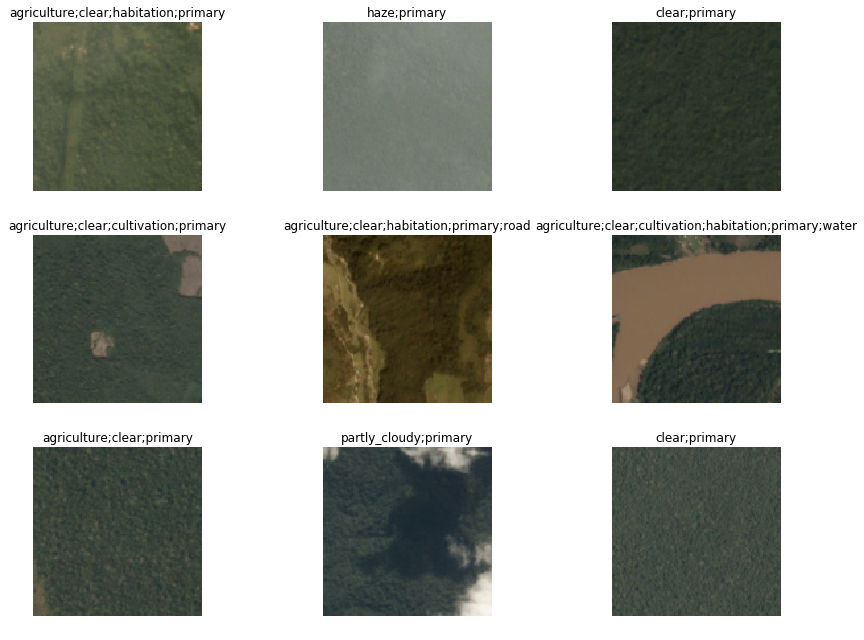

In [8]:
data.show_batch(rows=3, figsize=(12,9))

In [9]:
arch = models.resnet50

In [10]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/models')

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 115360815.65it/s]


We use the LR Finder to pick a good learning rate.

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


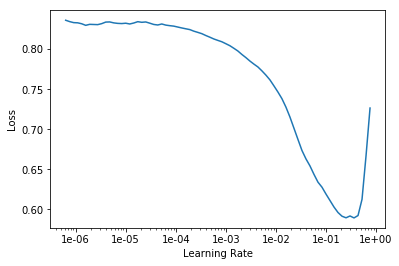

In [12]:
learn.recorder.plot()

Then we can fit the head of our network.

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126763,0.108859,0.947753,0.905040,04:26
1,0.110416,0.097360,0.952825,0.914343,03:44
2,0.103427,0.092199,0.957737,0.919979,03:43
3,0.093304,0.087600,0.956218,0.924585,03:43
4,0.090885,0.086325,0.955492,0.925205,03:41


In [15]:
learn.save('stage-1-rn50')

Fine-tuning the model:

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


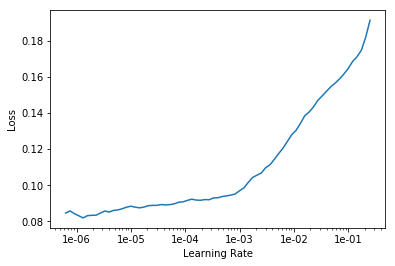

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096955,0.091473,0.954278,0.921708,03:59
1,0.099751,0.088685,0.956931,0.924820,03:57
2,0.090649,0.085323,0.959038,0.927321,03:57
3,0.087397,0.083459,0.958318,0.927648,03:57
4,0.080913,0.082410,0.959496,0.929797,03:57


In [19]:
learn.save('stage-2-rn50')

In [20]:
data = (src.transform(tfms, size=256)
        .databunch(num_workers=0).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


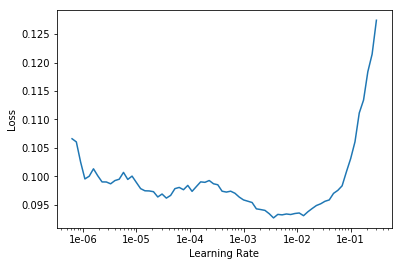

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr=1e-2/2

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091459,0.084279,0.956872,0.926981,07:43
1,0.086676,0.084352,0.957977,0.927170,07:40
2,0.085010,0.082953,0.956160,0.927574,07:37
3,0.082717,0.080843,0.959575,0.931228,07:40
4,0.081072,0.081288,0.960390,0.930548,07:38


In [25]:
learn.save('stage-1-256-rn50')

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085269,0.083054,0.957679,0.928573,08:31
1,0.084580,0.084668,0.955811,0.925123,08:34
2,0.082964,0.081999,0.959241,0.928613,08:30
3,0.079150,0.080823,0.959358,0.930704,08:31
4,0.074243,0.080720,0.959699,0.930751,08:31


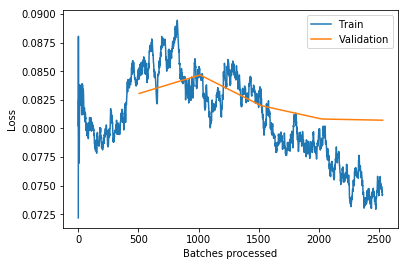

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save('stage-2-256-rn50')